Hi everyone! This is the notebook we will use tf.Keras to train/evaluate/predict a classifer for cat/dog/bird with convolutional layers. With tf.Keras things become very simple all we have to do is to combine codes from previous notebooks!

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.3.0


In [2]:
def show_images(dataset, class_names, predicts=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.8, wspace=0.4)
    for i, (image, label) in enumerate(dataset):
        if i>= 9: 
            break
        if image.shape[-1] == 1:
            revised_image = np.squeeze(image)
        else:
            revised_image = image
        axes.flat[i].imshow(revised_image)
        # Name of the true class.
        label_name = class_names[label]
        
        # Show true and predicted classes.
        if predicts is None:
            axes.flat[i].set_xlabel("True : {0}".format(label_name))
        else:
            predict_name = class_names[predicts[i]]
            axes.flat[i].set_xlabel("True: {0}\nPred: {1}".format(label_name, predict_name))
        # Remove ticks from the plot.
        axes.flat[i].set_xticks([])
        axes.flat[i].set_yticks([])
    while(i < 8):
        i += 1
        axes.flat[i].axis('off')
    plt.show()

In [3]:
class_names = ['bird','cat','dog']

Preparing Data: Search the filenames.

In [4]:
filenames = []
labels = []
for filename in os.listdir("./data"):
    if filename.startswith("bird"):
        labels.append(0)
        filenames.append(os.path.join("./data",filename))
    elif filename.startswith("cat"):
        labels.append(1)
        filenames.append(os.path.join("./data",filename))
    elif filename.startswith("dog"):
        labels.append(2)
        filenames.append(os.path.join("./data",filename))
print(filenames)
print(labels)

['./data\\bird (10).jpg', './data\\bird (11).jpg', './data\\bird (12).jpg', './data\\bird (13).jpg', './data\\bird (14).jpg', './data\\bird (15).jpg', './data\\bird (16).jpg', './data\\bird (17).jpg', './data\\bird (18).jpg', './data\\bird (19).jpg', './data\\bird (2).jpg', './data\\bird (20).jpg', './data\\bird (21).jpg', './data\\bird (22).jpg', './data\\bird (23).jpg', './data\\bird (24).jpg', './data\\bird (25).jpg', './data\\bird (26).jpg', './data\\bird (27).jpg', './data\\bird (28).jpg', './data\\bird (29).jpg', './data\\bird (3).jpg', './data\\bird (30).jpg', './data\\bird (31).jpg', './data\\bird (32).jpg', './data\\bird (33).jpg', './data\\bird (34).jpg', './data\\bird (35).jpg', './data\\bird (36).jpg', './data\\bird (37).jpg', './data\\bird (38).jpg', './data\\bird (39).jpg', './data\\bird (4).jpg', './data\\bird (40).jpg', './data\\bird (5).jpg', './data\\bird (6).jpg', './data\\bird (7).jpg', './data\\bird (8).jpg', './data\\bird (9).jpg', './data\\bird.jpg', './data\\cat

The same as in Data.ipynb.

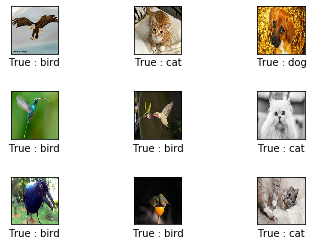

In [5]:
path_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
def load_and_preprocess_image(filename, label):
    raw_image = tf.io.read_file(filename)
    image_tensor = tf.image.decode_jpeg(raw_image)
    image_tensor = tf.image.resize(image_tensor, [224, 224])
    image_tensor /= 255.0
    return image_tensor,label
imageDataset = path_dataset.shuffle(buffer_size=100,reshuffle_each_iteration=False).map(load_and_preprocess_image)
show_images(imageDataset, class_names)

In [6]:
trainDataset = imageDataset.take(int(len(filenames)* 0.7))
valDataset = imageDataset.skip(int(len(filenames)* 0.7))

Preparing Model

In [7]:
cnnModel = keras.Sequential()
cnnModel.add(layers.Conv2D(input_shape=[224,224,3],filters = 16, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.MaxPool2D(pool_size = 4, strides = 4))
cnnModel.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 1,
                       activation = 'relu'))
cnnModel.add(layers.MaxPool2D(pool_size = 4, strides = 4))
cnnModel.add(layers.Flatten())
cnnModel.add(layers.Dense(units = 512, activation = 'relu'))
cnnModel.add(layers.Dense(units = 3, activation = 'softmax'))
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 51, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

Compiling Model

In [8]:
cnnModel.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
             loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

Training Procedure

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('keras_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
]
history = cnnModel.fit(trainDataset.batch(5).prefetch(buffer_size=10), epochs=20, validation_data=valDataset.batch(5), callbacks = callbacks)

Epoch 1/20
17/17 [==============================] - 4s 240ms/step - loss: 1.1719 - sparse_categorical_accuracy: 0.3929 - val_loss: 1.1487 - val_sparse_categorical_accuracy: 0.3056
Epoch 2/20
17/17 [==============================] - 4s 236ms/step - loss: 1.0597 - sparse_categorical_accuracy: 0.4524 - val_loss: 1.1052 - val_sparse_categorical_accuracy: 0.3056
Epoch 3/20
17/17 [==============================] - 4s 226ms/step - loss: 0.9821 - sparse_categorical_accuracy: 0.5714 - val_loss: 1.1078 - val_sparse_categorical_accuracy: 0.3889
Epoch 4/20
17/17 [==============================] - 4s 231ms/step - loss: 0.8579 - sparse_categorical_accuracy: 0.6310 - val_loss: 1.0952 - val_sparse_categorical_accuracy: 0.4444
Epoch 5/20
17/17 [==============================] - 4s 233ms/step - loss: 0.7316 - sparse_categorical_accuracy: 0.6786 - val_loss: 1.0118 - val_sparse_categorical_accuracy: 0.4444
Epoch 6/20
17/17 [==============================] - 4s 228ms/step - loss: 0.5920 - sparse_categorica

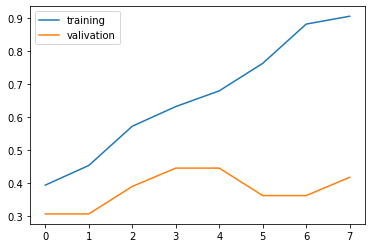

In [10]:
# history record the accuracy/loss on training set/validation set after every epoch 
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()

You must set the batch_size for the dataset before sending it to the model for training/evaluation.

In [11]:
result = cnnModel.evaluate(valDataset.batch(10))

4/4 [==============================] - 0s 68ms/step - loss: 1.4298 - sparse_categorical_accuracy: 0.4167


In [12]:
result

[1.429762363433838, 0.4166666567325592]

Prediction Phase

In [13]:
some_samples = valDataset.take(9)

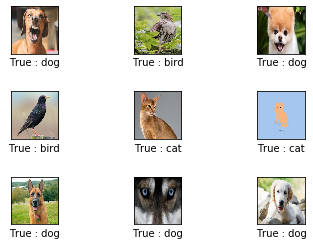

In [14]:
show_images(some_samples, class_names)

In [15]:
predict_result = tf.argmax(cnnModel.predict(some_samples.batch(9)),axis=1)

In [16]:
predict_result.numpy()

array([2, 1, 1, 0, 1, 0, 2, 0, 1], dtype=int64)

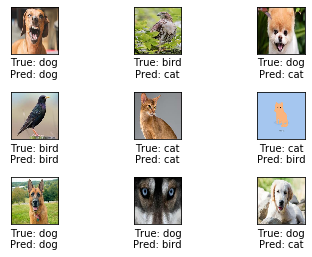

In [17]:
show_images(some_samples, class_names, predict_result)